## Imports

In [1]:
import os

import cv2
import numpy as np
from typing import Optional
from matplotlib import pyplot as plt

import tensorflow as tf
from keras.metrics import BinaryAccuracy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Parameters

In [2]:
class Parameters(object):
    def __init__(self) -> None:
        self.data_dir = './fire_dataset/'
        self.model_dir = './models'
        self.output_model_name = 'fire_detection_model.h5'
        self.image_extensions = ['.jpeg', '.png', '.jpg']
        self.train_size = 0.7 # 70%
        self.test_size = 0.2 # 20%
        self.val_size = 0.1 # 10%
        self.batch_size = 8
        self.image_shape = (256, 256, 3)

p = Parameters()

## Functions

In [3]:
def calculate_sizes_to_split_batches(batches : int, train_size : float=p.train_size, 
                                     test_size : float=p.test_size, val_size : float=p.val_size, verbose : bool=True) -> tuple[int, int, Optional[int]]:
    """
    Calculate the number of elements for training, testing, and validation sets based on the total number of batches.

    This function calculates the number of elements for training, testing, and validation sets
    based on the specified proportions and the total number of batches. It adjusts the sizes
    to ensure that the sum of elements in the sets is close to the total number of batches.

    Parameters
    ----------
    batches : int
        The total number of batches.
    train_size : float, optional
        The proportion of elements to be assigned to the training set (default is p.train_size).
    test_size : float, optional
        The proportion of elements to be assigned to the testing set (default is p.test_size).
    val_size : float, optional
        The proportion of elements to be assigned to the validation set (default is p.val_size).
    verbose : bool, optional
        If True, print information about the calculated sizes (default is True).

    Returns
    -------
    Tuple[int, int, int]
        A tuple containing the calculated number of elements for the training, testing, and validation sets.

    """

    if batches < 2:
        print(f"There is {batches} batches, you are required to have at least 2 batches.")
        return

    train_elements = int(batches * train_size)
    test_elements = int(batches * test_size)
    val_elements = int(batches * val_size)

    delta = (batches - (train_elements + test_elements + val_elements))

    if delta % 3 == 1:
        if test_elements == 0:
            test_elements += 1

        elif val_elements == 0 and val_size > 0:
            val_elements += 1

        else:
            val_elements += 1

    elif delta % 3 == 2:
        test_elements += 1
        val_elements += 1

    if verbose:
        print(f"For batches={batches}, Train elements: {train_elements}, Test elements: {test_elements}, Val elements: {val_elements}")
    
    return train_elements, test_elements, val_elements

def get_train_test_val_datasets(dataset : tf.data.Dataset, train_elements : int, 
                                test_elements : int, val_elements : int) -> tuple[tf.data.Dataset, tf.data.Dataset, Optional[tf.data.Dataset]]:
    """
    Split the input dataset into training, testing, and validation sets.

    This function divides the dataset into training, testing, and validation 
    sets based on the specified number of elements for each set.

    Parameters
    ----------
    dataset : tf.data.Dataset
        The input dataset to be split.
    train_elements : int
        The number of elements to include in the training set.
    test_elements : int
        The number of elements to include in the testing set.
    val_elements : int
        The number of elements to include in the validation set.

    Returns
    -------
    Tuple[tf.data.Dataset, tf.data.Dataset, Optional[tf.data.Dataset]]
        A tuple containing the training, testing, and validation datasets. 
        The validation dataset is optional and may be `None` if `val_elements` is zero.
    """

    train = dataset.take(train_elements)
    test = dataset.skip(train_elements).take(test_elements)

    if val_elements > 0:
        val = dataset.skip(train_elements+test_elements).take(val_elements)

    else:
        val = None

    return train, test, val

def frame_image(img: np.ndarray, frame_width: int, correct: bool) -> np.ndarray:
    """
    Frame the input image with a border of specified width.

    This function adds a border to the input image. The color of the border can
    be either green or red, based on the value of the 'correct' parameter.

    Parameters
    ----------
    img : numpy.ndarray
        Input image as a NumPy array.
    frame_width : int
        Width of the border to be added to the image.
    correct : bool
        If True, the frame will be green; if False, the frame will be red.

    Returns
    -------
    numpy.ndarray
        Image with the specified border color.

    References
    ----------
    [1] https://stackoverflow.com/questions/43261338/adding-a-border-to-and-image-in-my-code
    """

    b = frame_width # border size in pixel
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y

    if img.ndim == 3: # rgb or rgba array

        framed_img = np.zeros((b+ny+b, b+nx+b, img.shape[2]))

    elif img.ndim == 2: # grayscale image

        framed_img = np.zeros((b+ny+b, b+nx+b))

    framed_img[b:-b, b:-b] = img
    
    if correct:

        framed_img[:b, :, :] = [0, 255, 0]  # Green frame
        framed_img[-b:, :, :] = [0, 255, 0]  # Green frame
        framed_img[:, :b, :] = [0, 255, 0]  # Green frame
        framed_img[:, -b:, :] = [0, 255, 0]  # Green frame

    else:

        framed_img[:b, :, :] = [255, 0, 0]  # Red frame
        framed_img[-b:, :, :] = [255, 0, 0]  # Red frame
        framed_img[:, :b, :] = [255, 0, 0]  # Red frame
        framed_img[:, -b:, :] = [255, 0, 0]  # Red frame

    framed_img = np.clip(framed_img, 0, 255).astype(np.uint8)
    
    return framed_img

def get_class_weights(train: tf.data.Dataset, verbose : bool=False): 
    """
    Calculate class weights for imbalanced training data.

    This function calculates class weights based on the training dataset to handle imbalanced data.
    It uses the 'balanced' option in `compute_class_weight` to automatically compute weights inversely
    proportional to class frequencies in the training dataset.

    Parameters
    ----------
    train : tf.data.Dataset
        Training dataset containing input features and labels.
    verbose : bool, optional
        If True, print the calculated class weights (default is False).

    Returns
    -------
    np.ndarray
        An array containing the calculated class weights.

    """
      
    train_labels = []

    for label_batch in train:
        train_labels.extend(label_batch[1].numpy().tolist())

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

    if verbose:

        class_weights_dict = dict(zip(np.unique(train_labels), class_weights))

        for label, weight in class_weights_dict.items():
            print(f"Class {label} Weight: {weight}")
    
    return class_weights


## Data Loading & Preprocessing

#### Overall Structure of the Dataset

![Data Structure](./img/Data.png)

### Data Loading

In [4]:
for image_class in os.listdir(p.data_dir):
    for image in os.listdir(os.path.join(p.data_dir, image_class)):
        image_path = os.path.join(p.data_dir, image_class, image)

        try:
            img = cv2.imread(image_path)

            name, extension = os.path.splitext(image)
            if extension.lower() not in p.image_extensions:
                os.remove(image_path)
                print(f'Removing Image -> {image_path}')
        
        except Exception as e:
            print(f'Exception {e} with file {image_path}')

In [5]:
dataset = tf.keras.utils.image_dataset_from_directory('./fire_dataset/', image_size=(256, 256), batch_size=p.batch_size, shuffle=True)

Found 999 files belonging to 2 classes.


### Normalization

In [6]:
dataset = dataset.map(lambda x,y: (x/255, y))

### Dividing Train, Test and Validation Batches

In [7]:
train_elements, test_elements, val_elements = calculate_sizes_to_split_batches(len(dataset))

For batches=125, Train elements: 87, Test elements: 25, Val elements: 13


In [8]:
train, test, val = get_train_test_val_datasets(dataset, train_elements, test_elements, val_elements)

## Model Setup & Training

### Model Definition

In [9]:
cnn_model = Sequential([
    Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = p.image_shape),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(32,activation='relu'),
    Dense(1,activation = 'sigmoid')
    
])
model = cnn_model

In [10]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 32)                16516128  
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                        

### Getting Class Weights

In [11]:
class_weights = get_class_weights(train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

### Training the model

In [12]:
# Train the model for 50 epochs with early stopping
hist = model.fit(train, epochs=5, validation_data=test, class_weight=class_weights_dict)

Epoch 1/5
87/87 [==============================] - 47s 498ms/step - loss: 1.8348 - accuracy: 0.8161 - val_loss: 0.2221 - val_accuracy: 0.9200
Epoch 2/5
87/87 [==============================] - 50s 566ms/step - loss: 0.1476 - accuracy: 0.9425 - val_loss: 0.1498 - val_accuracy: 0.9550
Epoch 3/5
87/87 [==============================] - 50s 566ms/step - loss: 0.1374 - accuracy: 0.9626 - val_loss: 0.1780 - val_accuracy: 0.9550
Epoch 4/5
87/87 [==============================] - 53s 585ms/step - loss: 0.1222 - accuracy: 0.9511 - val_loss: 0.1115 - val_accuracy: 0.9550
Epoch 5/5
87/87 [==============================] - 49s 541ms/step - loss: 0.0687 - accuracy: 0.9641 - val_loss: 0.0667 - val_accuracy: 0.9850


## Evaluation

### Initializing Evaluation Metrics

In [13]:
accuracy = BinaryAccuracy()

### Defining Subplots

In [14]:
y_amount = val_elements * p.batch_size

columns = 8
quotient, remainder = divmod(y_amount, columns)

rows = quotient
if remainder:
    rows = rows + 1

### Evaluating Validation Set

![Interpreting_validation_results](./img/IntValidation.png)

1/1 [==============================] - 0s 95ms/step


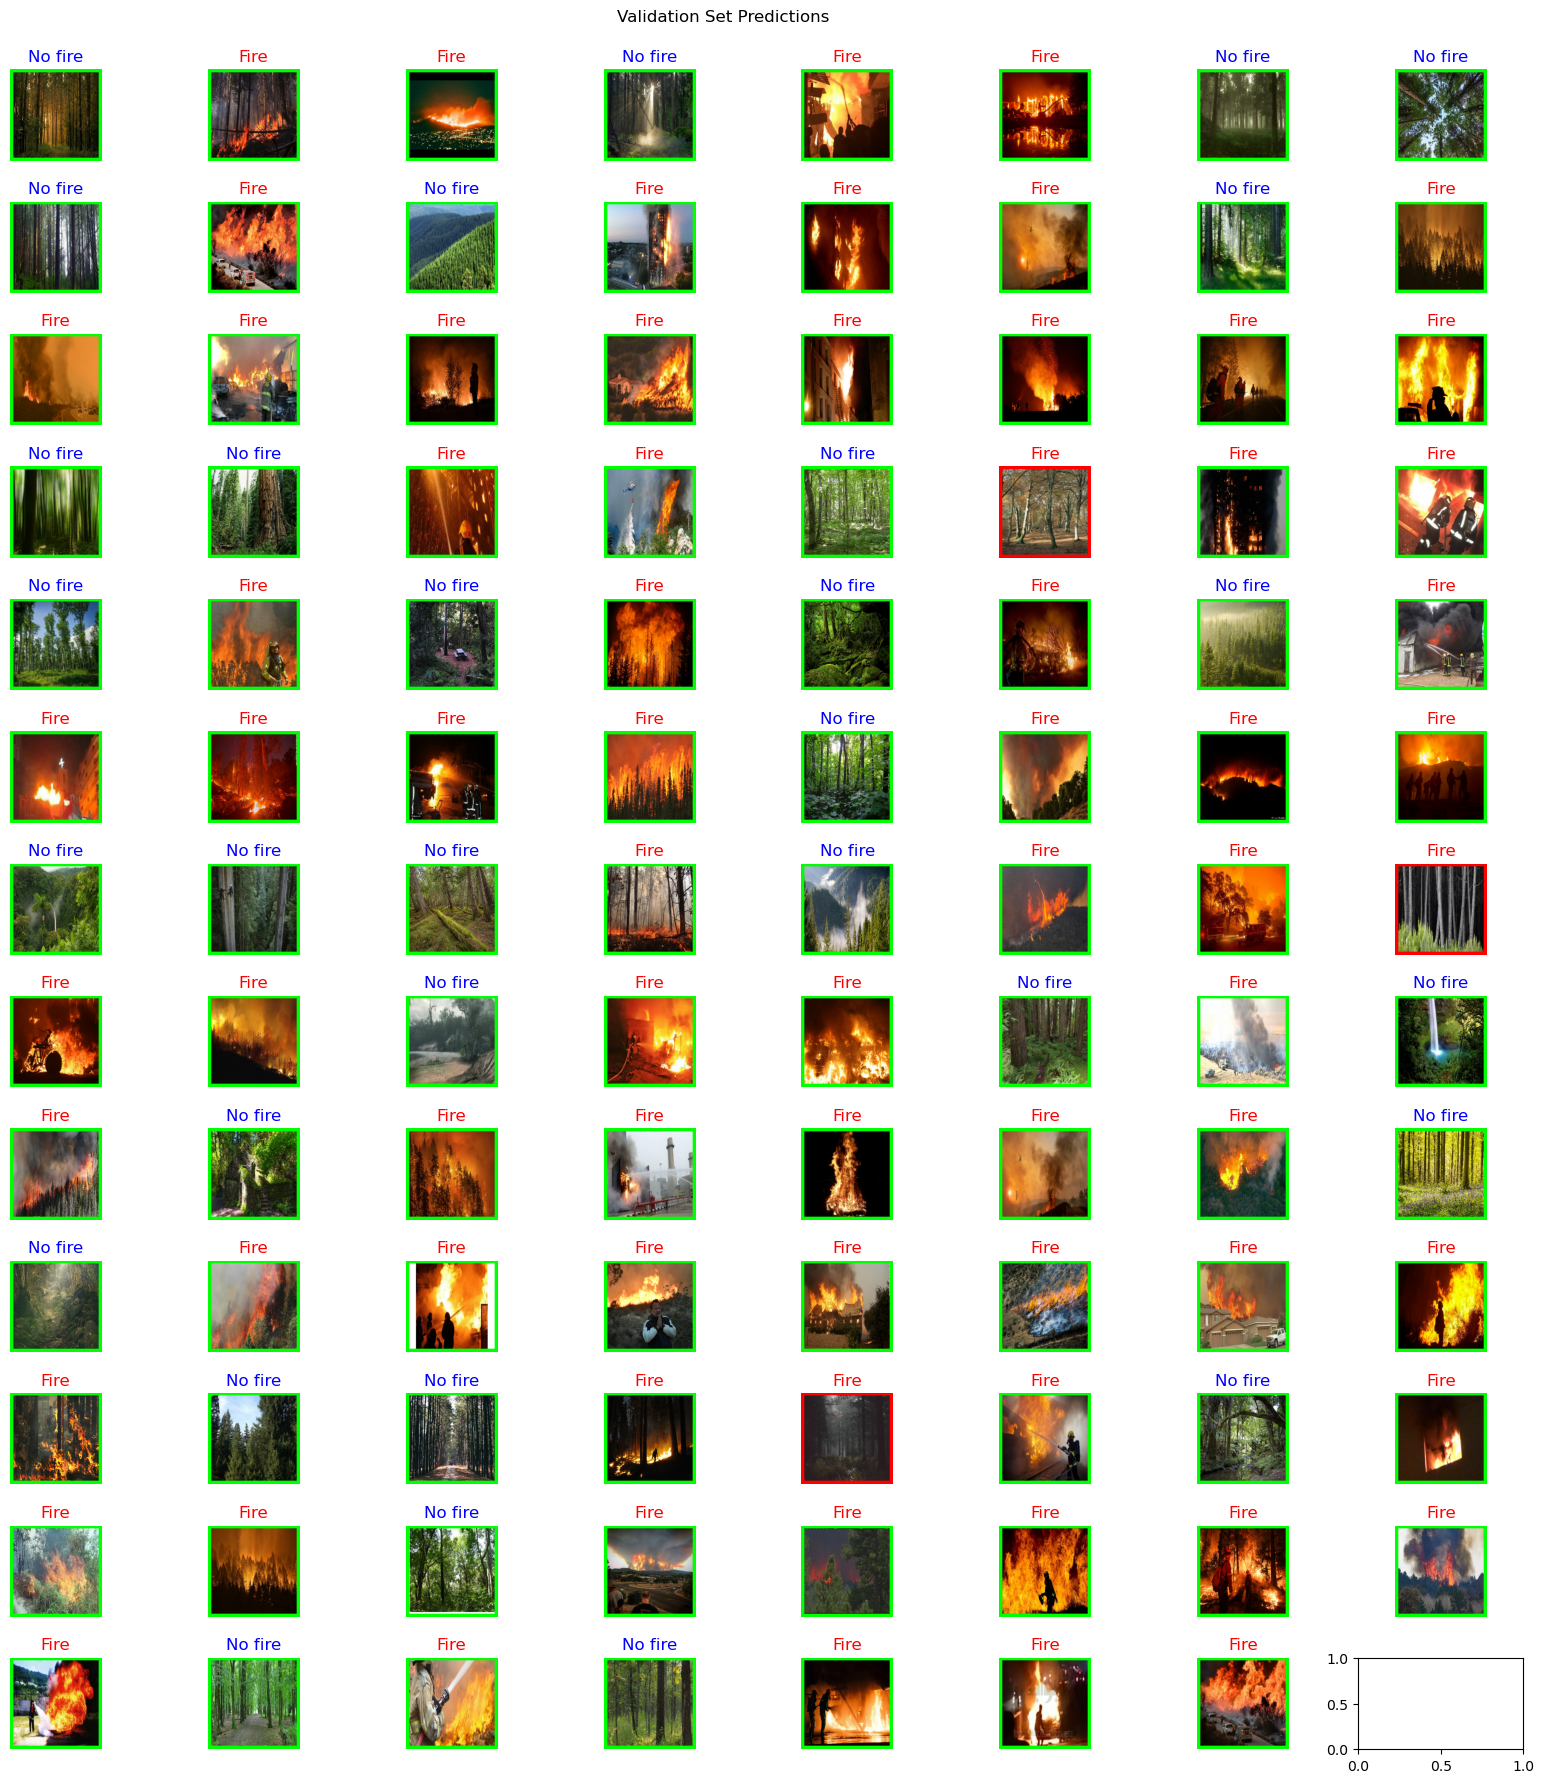

In [15]:
fig, axs= plt.subplots(rows, columns, figsize=(20, 20))

const = 1

cm_y = []
cm_yhat = []

for batch in val.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X).round()


    cm_y.extend(list(y))
    cm_yhat.extend([element.item() for element in yhat])

    
    for image, y_image, y_true in zip(X, yhat, y):
 
        axs = plt.subplot(rows, columns, const)

        axs.axis('off')

        if int(y_image[0]) == 0:
            axs.set_title('Fire', color='r')
        
        else:
            axs.set_title('No fire', color='b')
            
        const += 1


        if y_image == y_true:
            axs.imshow(frame_image(image * 255, 10, True))

        else:
            axs.imshow(frame_image(image * 255, 10, False))

    accuracy.update_state(y, yhat)


plt.subplots_adjust(hspace=0.45, top=0.95)
plt.suptitle('Validation Set Predictions')
plt.show()

### Evaluation Metrics on Validation Set

In [16]:
print(f"Accuracy: {accuracy.result().numpy()}")

Accuracy: 0.9708737730979919


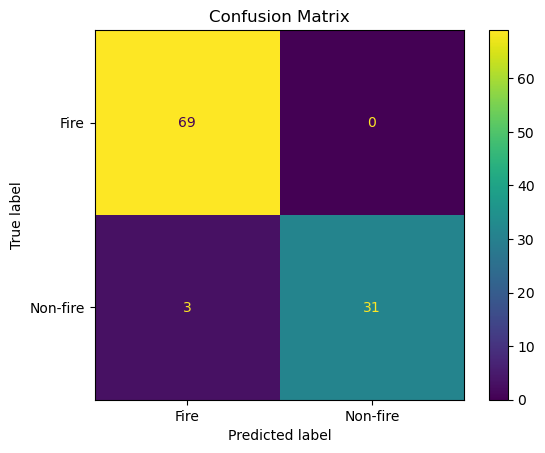

In [17]:
cm = confusion_matrix(cm_y, cm_yhat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fire', 'Non-fire'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

## Saving the model

In [18]:
if not os.path.exists(p.model_dir):
    os.makedirs(p.model_dir)

model.save(f'{p.model_dir}/{p.output_model_name}')

c:\Users\loren\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
